<a href="https://colab.research.google.com/github/sakibchowdhury131/railcop/blob/main/spectrogram_CNN_65%25valAccuracy_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
np.random.seed(1)

import tensorflow as tf
tf.random.set_seed(1)

In [3]:
import os
from tensorflow import keras
import matplotlib.pyplot as plt
import math
import pandas as pd

In [4]:
label0 = pd.read_csv('/content/drive/MyDrive/RailCop/New Files/Sakib/data/label0/Copy of train_1.csv')
label1 = pd.read_csv('/content/drive/MyDrive/RailCop/New Files/Sakib/data/label1/Copy of train_1.csv')
print(label1)

      Sensor1  Sensor2  ...  Sensor2+Sensor4  Sensor1+Sensor2+Sensor3
0           2        9  ...               10                       12
1           4        9  ...                9                       13
2           4        9  ...               11                       15
3           4       11  ...               12                       16
4           2        9  ...               10                       12
...       ...      ...  ...              ...                      ...
5384        3        9  ...               10                       13
5385        3       10  ...               11                       14
5386        4        8  ...                9                       13
5387        3        9  ...               10                       13
5388        3       10  ...               12                       15

[5389 rows x 7 columns]


In [5]:
__fullVector0 = label0['Sensor1+Sensor2+Sensor3'].to_numpy()
__fullVector1 = label1['Sensor1+Sensor2+Sensor3'].to_numpy()


print(__fullVector0.shape)
print(__fullVector1.shape)


(23050,)
(5389,)


In [49]:
__frameSize = 50

## label 0 framing

__numFrames0 = int(__fullVector0.shape[0] / __frameSize)
__frames0 = np.zeros((__numFrames0,__frameSize))
for i in range (0, __numFrames0):
  for j in range (0, __frameSize):
    __frames0[i][j] = __fullVector0[i*__frameSize+j]

In [50]:
## label 1 framing

__numFrames1 = int(__fullVector1.shape[0] / __frameSize)
__frames1 = np.zeros((__numFrames1,__frameSize))
for i in range (0, __numFrames1):
  for j in range (0, __frameSize):
    __frames1[i][j] = __fullVector1[i*__frameSize+j]

In [51]:
__frames0.shape

(461, 50)

In [52]:
__frames1.shape

(107, 50)

In [53]:
__maxFrames = __frames1.shape[0]
__label0 = __frames0[0:__maxFrames, :]
__label1 = __frames1[0:__maxFrames, :]

In [69]:
__label0.shape

(107, 50)

In [73]:
X0 = np.zeros((__label0.shape[0],6,6))
for i in range(0, __label0.shape[0]):
  t, f, X0[i,:,:] = spectrogram(__frames0[i])

In [74]:
X1 = np.zeros((__label1.shape[0],6,6))
for i in range(0, __label1.shape[0]):
  t, f, X1[i,:,:] = spectrogram(__frames1[i])

In [75]:
X = np.asarray(np.concatenate((X0, X1), axis = 0), dtype=np.float32)

In [77]:
Y0 = np.zeros(__label0.shape[0])
Y1 = np.ones(__label1.shape[0])
print(Y0.shape)
print(Y1.shape)

(107,)
(107,)


In [78]:
Y = np.asarray(np.concatenate((Y0, Y1), axis = 0), dtype=np.float32)

In [79]:
Y.shape

(214,)

In [55]:
## Applying DFT
## finding Fourier Co-efficients Xn

def get_xn(samples,n):
    L  = len(samples)
    ks = np.arange(0,L,1)
    xn = np.sum(samples*np.exp((1j*2*np.pi*ks*n)/L))/L
    return(xn)

In [56]:
## Compute Fourier coefficients only up to the Nyquest Limit Xn, n=1,...,L/2 and 
## multiply the absolute value of the Fourier coefficients by 2, to account for 
## the symetry of the Fourier coefficients above the Nyquest Limit.


def get_xns(samples):
    mag = []
    L = len(samples)
    for n in range(int(L/2)): # Nyquest Limit
        mag.append(np.abs(get_xn(samples,n))*2)
    return(mag)
mag = get_xns(__frames0[4])

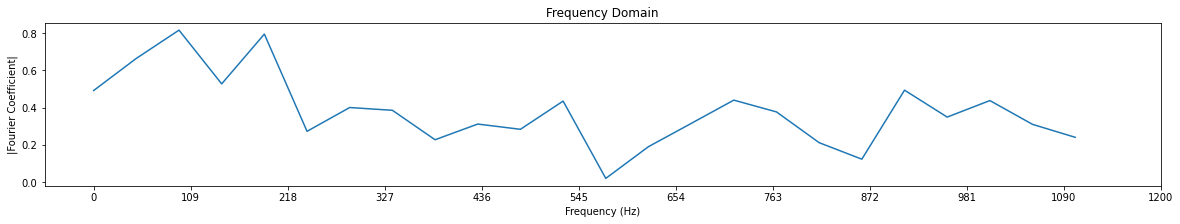

In [57]:
## Fourier Plot 

def get_Hz_scale_vec(ks,sample_rate,Npoints):
    freq_Hz = ks*sample_rate/Npoints
    freq_Hz  = [int(i) for i in freq_Hz ] 
    return(freq_Hz )
Nxlim = 12
sample_rate = int(9600/4)             
ks   = np.linspace(0,len(mag),Nxlim)
ksHz = get_Hz_scale_vec(ks,sample_rate,len(__frames1[0]))

plt.figure(figsize=(20,3))
plt.plot(mag[1:])
plt.xticks(ks,ksHz)
plt.title("Frequency Domain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("|Fourier Coefficient|")
plt.show()

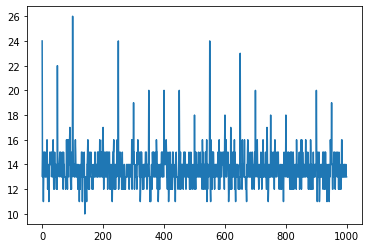

In [36]:
plt.plot (__label0[3])

In [58]:
## Fourier coefficients of label0 
__fourier0 = np.zeros((__maxFrames,len(mag)))
for i in range(0, __maxFrames):
  __fourier0[i] = np.array(get_xns(__label0[i]))



## Fourier coefficients of label1 
__fourier1 = np.zeros((__maxFrames,len(mag)))
for i in range(0, __maxFrames):
  __fourier1[i] = np.array(get_xns(__label1[i]))

In [59]:
X = np.asarray(np.concatenate((__fourier0[:, 1:], __fourier1[:, 1:]), axis = 0), dtype=np.float32)
Y = np.asarray(np.concatenate((Y0, Y1), axis = 0), dtype = np.float32)
print(X.shape)
print(Y.shape)

(214, 24)
(214,)


In [80]:
from sklearn.utils import shuffle
X, Y = shuffle(X,Y)

In [40]:
X.shape

(10, 499)

### Performing Spectrogram

In [41]:
from scipy import signal

In [64]:
def spectrogram(sig_in):
    nperseg = 10 # default 256
    noverlap = nperseg // 4 # default: nperseg // 8
    fs = sample_rate# raw signal sample rate is 8000Hz
    window = 'triang'
    scaling = 'density' # {'density', 'spectrum'}
    detrend = 'linear' # {'linear', 'constant', False}
    eps = 1e-11
    f, t, Sxx = signal.spectrogram(sig_in, nperseg=nperseg, noverlap=noverlap,
                                   fs=fs, window=window,
                                   scaling=scaling, detrend=detrend)
    return f, t, np.log(Sxx + eps)

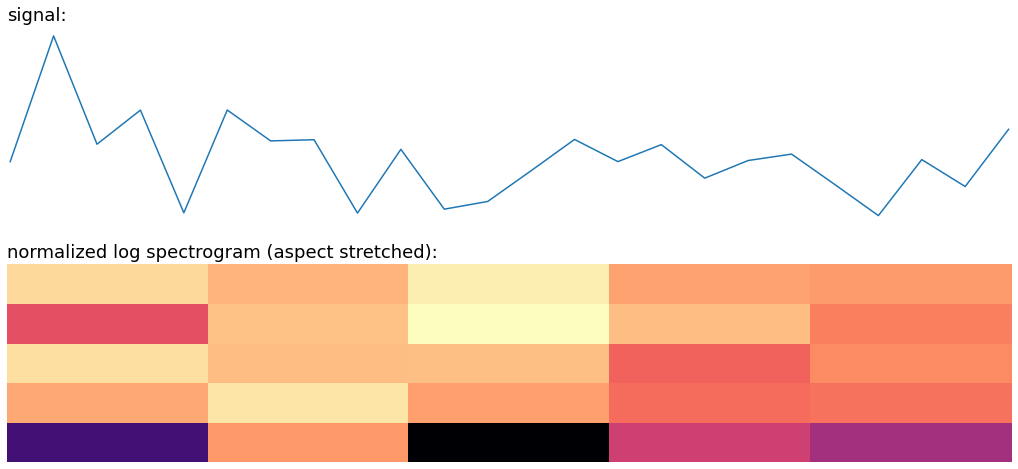

In [65]:
frame_index = 2
f, t, Sxx_out = spectrogram(__frames1[frame_index, :])

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(2, 1, 1)
ax.margins(x=0.003)
plt.plot(X[frame_index, :])
plt.title('signal:', fontsize=18, loc='left')
plt.axis('off')

ax = fig.add_subplot(2, 1, 2)
cmap = plt.get_cmap('magma')
spec = plt.pcolormesh(t, f, Sxx_out, cmap=cmap)
plt.title('normalized log spectrogram (aspect stretched):',
          fontsize=18, loc='left')
plt.axis('off');

In [68]:
Sxx_out.shape

(6, 6)

In [89]:
X.shape

(214, 6, 6)

In [94]:
def network():
  __input = keras.Input((X.shape[1], X.shape[2],1))
  __conv1 = keras.layers.Conv2D(filters = 8, kernel_size = 3, activation = 'relu')(__input)
  _#_conv1 = keras.layers.Conv2D(filters = 8, kernel_size = 3, activation = 'relu')(__conv1)
  #__conv1 = keras.layers.GRU(8)(__conv1)
  __flat1 = keras.layers.Flatten()(__conv1)
  __dense1 = keras.layers.Dense(8, activation = 'relu')(__flat1)
  __output = keras.layers.Dense(1, activation = 'sigmoid')(__dense1)

  model = keras.Model(inputs = __input, outputs = __output)
  return model 



model = network()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 6, 6, 1)]         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 8)           80        
                                                                 
 flatten_4 (Flatten)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 8)                 1032      
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [95]:
model.compile(loss='binary_crossentropy',
                      optimizer= 'adam',
                      metrics=['accuracy'])

In [96]:
__modelVersion = '__timeSeriesTest1.0'

weight_saver = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/RailCop/New Files/Sakib/models/'+__modelVersion, monitor='val_accuracy', 
                                save_best_only=True, save_weights_only=False, mode= 'max')

annealer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5,mode= 'min')


hist = model.fit( x = X , 
                  y = Y, 
                  batch_size = 4,
                  epochs = 600,
                  callbacks = [weight_saver , annealer],
                  validation_split = 0.2,
                  shuffle = True,
                  verbose = 1)

Epoch 1/600
32/43 [=====================>........] - ETA: 0s - loss: 0.7808 - accuracy: 0.4922 INFO:tensorflow:Assets written to: /content/drive/MyDrive/RailCop/New Files/Sakib/models/__timeSeriesTest1.0/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RailCop/New Files/Sakib/models/__timeSeriesTest1.0/assets


43/43 [==============================] - 1s 24ms/step - loss: 0.7851 - accuracy: 0.4795 - val_loss: 0.7586 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 2/600
43/43 [==============================] - 0s 3ms/step - loss: 0.7186 - accuracy: 0.5146 - val_loss: 0.7103 - val_accuracy: 0.5349 - lr: 0.0010
Epoch 3/600
43/43 [==============================] - 0s 3ms/step - loss: 0.7173 - accuracy: 0.4854 - val_loss: 0.7024 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 4/600
43/43 [==============================] - 0s 3ms/step - loss: 0.7399 - accuracy: 0.5380 - val_loss: 0.7158 - val_accuracy: 0.5581 - lr: 0.0010
Epoch 5/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.5556 - val_loss: 0.6917 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 6/600
31/43 [====================>.........] - ETA: 0s - loss: 0.6698 - accuracy: 0.5887INFO:tensorflow:Assets written to: /content/drive/MyDrive/RailCop/New Files/Sakib/models/__timeSeriesTest1.0/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RailCop/New Files/Sakib/models/__timeSeriesTest1.0/assets


43/43 [==============================] - 1s 21ms/step - loss: 0.6824 - accuracy: 0.5673 - val_loss: 0.6930 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 7/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6780 - accuracy: 0.5965 - val_loss: 0.7006 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 8/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6590 - accuracy: 0.5789 - val_loss: 0.7076 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 9/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6481 - accuracy: 0.6491 - val_loss: 0.7000 - val_accuracy: 0.5349 - lr: 0.0010
Epoch 10/600
43/43 [==============================] - 0s 2ms/step - loss: 0.6654 - accuracy: 0.5848 - val_loss: 0.6855 - val_accuracy: 0.5581 - lr: 0.0010
Epoch 11/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6637 - accuracy: 0.5906 - val_loss: 0.6809 - val_accuracy: 0.5581 - lr: 0.0010
Epoch 12/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6503 - ac

INFO:tensorflow:Assets written to: /content/drive/MyDrive/RailCop/New Files/Sakib/models/__timeSeriesTest1.0/assets


43/43 [==============================] - 1s 24ms/step - loss: 0.6256 - accuracy: 0.6550 - val_loss: 0.6858 - val_accuracy: 0.6279 - lr: 0.0010
Epoch 17/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.6374 - val_loss: 0.6729 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 18/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6565 - accuracy: 0.6199 - val_loss: 0.7032 - val_accuracy: 0.5349 - lr: 0.0010
Epoch 19/600
30/43 [===================>..........] - ETA: 0s - loss: 0.6344 - accuracy: 0.6917INFO:tensorflow:Assets written to: /content/drive/MyDrive/RailCop/New Files/Sakib/models/__timeSeriesTest1.0/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/RailCop/New Files/Sakib/models/__timeSeriesTest1.0/assets


43/43 [==============================] - 1s 21ms/step - loss: 0.6340 - accuracy: 0.6667 - val_loss: 0.6659 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 20/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6115 - accuracy: 0.6784 - val_loss: 0.6741 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 21/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6238 - accuracy: 0.6784 - val_loss: 0.6702 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 22/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6102 - accuracy: 0.6901 - val_loss: 0.6706 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 23/600
43/43 [==============================] - 0s 2ms/step - loss: 0.6155 - accuracy: 0.6667 - val_loss: 0.6688 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 24/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6349 - accuracy: 0.6608 - val_loss: 0.6736 - val_accuracy: 0.6279 - lr: 0.0010
Epoch 25/600
43/43 [==============================] - 0s 3ms/step - loss: 0.6057 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/RailCop/New Files/Sakib/models/__timeSeriesTest1.0/assets


43/43 [==============================] - 1s 21ms/step - loss: 0.5798 - accuracy: 0.7251 - val_loss: 0.6625 - val_accuracy: 0.6744 - lr: 2.5000e-04
Epoch 39/600
43/43 [==============================] - 0s 3ms/step - loss: 0.5748 - accuracy: 0.7310 - val_loss: 0.6615 - val_accuracy: 0.6512 - lr: 2.5000e-04
Epoch 40/600
43/43 [==============================] - 0s 3ms/step - loss: 0.5736 - accuracy: 0.7193 - val_loss: 0.6625 - val_accuracy: 0.6512 - lr: 2.5000e-04
Epoch 41/600
43/43 [==============================] - 0s 3ms/step - loss: 0.5737 - accuracy: 0.7135 - val_loss: 0.6627 - val_accuracy: 0.6512 - lr: 2.5000e-04
Epoch 42/600
43/43 [==============================] - 0s 3ms/step - loss: 0.5698 - accuracy: 0.7310 - val_loss: 0.6620 - val_accuracy: 0.6744 - lr: 2.5000e-04
Epoch 43/600
43/43 [==============================] - 0s 3ms/step - loss: 0.5710 - accuracy: 0.7310 - val_loss: 0.6622 - val_accuracy: 0.6279 - lr: 2.5000e-04
Epoch 44/600
43/43 [==============================] - 0s 2

KeyboardInterrupt: ignored